In [2]:
import numpy as np
import random
import json
import copy
from typing import List, Tuple
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [3]:
def eliminacao_gauss(A, b, max_iter):
    n = len(A)
    for i in range(n):
        max_index = max(range(i, n), key=lambda k: abs(A[k][i]))
        if A[max_index][i] == 0:
            raise ValueError(f"A matriz é singular, não é possível resolver o sistema para a linha {i}.")
        if max_index != i:
            A[i], A[max_index] = A[max_index], A[i]
            b[i], b[max_index] = b[max_index], b[i]
        for k in range(i + 1, n):
            fator = A[k][i] / A[i][i]
            for j in range(i, n):
                A[k][j] -= fator * A[i][j]
            b[k] -= fator * b[i]
    x = [0] * n
    for i in range(n - 1, -1, -1):
        soma = sum(A[i][j] * x[j] for j in range(i + 1, n))
        x[i] = (b[i] - soma) / A[i][i]
    for _ in range(max_iter):
        r = [b[i] - sum(A[i][j] * x[j] for j in range(n)) for i in range(n)]
        delta_x = [0] * n
        for i in range(n - 1, -1, -1):
            soma = sum(A[i][j] * delta_x[j] for j in range(i + 1, n))
            delta_x[i] = (r[i] - soma) / A[i][i]
        x = [x[i] + delta_x[i] for i in range(n)]
    
    return x

In [4]:
def metodo_jacobi(A, b, max_iter, tol=1e-6):
    n = len(A)
    x = [0] * n 
    x_novo = x[:]
    for _ in range(max_iter):
        for i in range(n):
            soma = sum(A[i][j] * x[j] for j in range(n) if j != i)
            x_novo[i] = (b[i] - soma) / A[i][i]
        if max(abs(x_novo[i] - x[i]) for i in range(n)) < tol:
            return x_novo
        x = x_novo[:]
    return x_novo

In [5]:
def metodo_gauss_seidel(A, b, max_iter, tol=1e-6):
    n = len(A)
    x = [0] * n 
    for _ in range(max_iter):
        x_old = x[:]
        for i in range(n):
            soma = sum(A[i][j] * x[j] for j in range(n) if j != i)
            x[i] = (b[i] - soma) / A[i][i]
        if max(abs(x[i] - x_old[i]) for i in range(n)) < tol:
            return x
    return x

In [6]:
class Individual:
    def __init__(self, initial_positions: List[List[float]], min_matrix: List[List[float]], 
                 max_matrix: List[List[float]], b_vector: List[float]):
        self.initial_positions = initial_positions
        self.min_matrix = min_matrix
        self.max_matrix = max_matrix
        self.b_vector = b_vector
        self.n = len(initial_positions)
        self.graph = self._initialize_graph()
    
    def _initialize_graph(self) -> List[List[float]]:
        graph = [[0.0] * self.n for _ in range(self.n)]
        for i in range(self.n):
            for j in range(self.n):
                if self.max_matrix[i][j] > 0:
                    val = self.initial_positions[i][j] * random.uniform(
                        self.min_matrix[i][j], self.max_matrix[i][j])
                    graph[i][j] = val
                    graph[j][i] = val
        return graph

    def fitness(self, tester: List[List[float]]) -> float:
        n = len(self.initial_positions)
        pontuacoes = []
    
        for _ in range(5):
            A = [[0.0] * n for _ in range(n)]
            for i in range(n):
                for j in range(n):
                    A[i][j] = self.initial_positions[i][j] * tester[i][j]
    
            try:
                solution = eliminacao_gauss(A, self.b_vector.copy(), 5)
                total_abs = sum(abs(x) for x in solution) 
                if total_abs == 0:
                    pontuacoes.append(0.0)
                else:
                    pontuacoes.append( n / total_abs)
            except ValueError: 
                pontuacoes.append(0.0)
    
        return sum(pontuacoes)

    def mutate(self, mutation_rate: float) -> 'Individual':
        new_positions = copy.deepcopy(self.initial_positions)
        for i in range(self.n):
            for j in range(self.n):
                if i != j and random.random() < mutation_rate:
                    new_positions[i][j] = 1 - new_positions[i][j]
                    new_positions[j][i] = new_positions[i][j]
        return Individual(new_positions, self.min_matrix, self.max_matrix, self.b_vector)

    def randomize(self) -> 'Individual':
        new_positions = [[1 if i==j else 0 for j in range(self.n)] for i in range(self.n)]
        for i in range(self.n):
            for j in range(i+1, self.n):
                if random.random() < 0.5:
                    new_positions[i][j] = 1
                    new_positions[j][i] = 1
        return Individual(new_positions, self.min_matrix, self.max_matrix, self.b_vector)

    def cross(self, other: 'Individual') -> 'Individual':
        new_positions = copy.deepcopy(self.initial_positions)
        for i in range(self.n):
            for j in range(self.n):
                if i != j and random.random() < 0.5:
                    new_positions[i][j] = other.initial_positions[i][j]
                    new_positions[j][i] = new_positions[i][j]
        return Individual(new_positions, self.min_matrix, self.max_matrix, self.b_vector)

    def copy(self) -> 'Individual':
        return Individual(
            copy.deepcopy(self.initial_positions), 
            self.min_matrix,
            self.max_matrix,
            copy.deepcopy(self.b_vector)
        )

    def get_graph(self) -> List[List[float]]:
        return self.graph

    def get_b(self) -> List[float]:
        return self.b_vector

    def __str__(self) -> str:
        return f"Individual:\n{self.initial_positions}"

In [7]:
def generate_tester(initial_positions: List[List[float]], min_matrix: List[List[float]], 
                    max_matrix: List[List[float]]) -> List[List[float]]:
    n = len(initial_positions)
    tester = [[0.0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if max_matrix[i][j] > 0:
                val = random.uniform(min_matrix[i][j], max_matrix[i][j])
                tester[i][j] = val
                tester[j][i] = val
    return tester

In [8]:
def select_parent_torneio(population: List[Individual], fitness: List[float], 
                          tournament_size: int) -> List[Individual]:
    selected = []
    for _ in range(2):
        tournament = random.sample(list(zip(population, fitness)), tournament_size)
        best = max(tournament, key=lambda x: x[1])[0]
        selected.append(best)
    return selected

In [9]:
def run_ag(initial_positions: List[List[float]], min_matrix: List[List[float]], 
           max_matrix: List[List[float]], b_vector: List[float]) -> Individual:
    template = Individual(initial_positions, min_matrix, max_matrix, b_vector)
    tester = generate_tester(initial_positions, min_matrix, max_matrix)
    
    population = [template.copy()]
    for _ in range(1, POP_SIZE):
        population.append(template.randomize())
    
    best_individual = None
    best_fitness = float('-inf')
    history = []
    
    for gen in range(GEN):
        fitness_list = [ind.fitness(tester) for ind in population]
        
        # Melhor indivíduo da geração atual
        current_best_idx = np.argmax(fitness_list)
        current_best = population[current_best_idx]
        current_fitness = fitness_list[current_best_idx]
        
        # Atualiza o melhor global se necessário
        if current_fitness > best_fitness:
            best_fitness = current_fitness
            best_individual = current_best.copy()
        
        # Armazena o melhor fitness da geração atual
        history.append(current_fitness)
        
        new_population = []
        while len(new_population) < POP_SIZE:
            parents = select_parent_torneio(population, fitness_list, 3)
            child = parents[0].cross(parents[1])
            child = child.mutate(MU_TAX)
            new_population.append(child)
        
        population = new_population
    
    return best_individual, history

In [10]:
def best_realocate(initial_positions, min_matrix, max_matrix, b):
    return run_ag(initial_positions, min_matrix, max_matrix, b)

In [11]:
def run_ag_island(initial_positions: List[List[float]], min_matrix: List[List[float]], 
                  max_matrix: List[List[float]], b_vector: List[float], 
                  num_islands: int, migration_interval: int, migration_size: int
                 ) -> Tuple[Individual, List[List[float]]]:
    template = Individual(initial_positions, min_matrix, max_matrix, b_vector)
    tester = generate_tester(initial_positions, min_matrix, max_matrix)
    
    # Histórico agora será uma lista de listas, uma para cada ilha
    history = [[] for _ in range(num_islands)]
    islands = []

    for _ in range(num_islands):
        pop = [template.copy()]
        for _ in range(1, POP_SIZE):
            pop.append(template.randomize())
        islands.append(pop)

    best_global = None
    best_global_fitness = float('-inf')

    for gen in range(GEN):
        for island_idx in range(num_islands):
            pop = islands[island_idx]
            fitness_list = [ind.fitness(tester) for ind in pop]

            current_best_idx = np.argmax(fitness_list)
            current_best = pop[current_best_idx]
            current_fitness = fitness_list[current_best_idx]

            if current_fitness > best_global_fitness:
                best_global_fitness = current_fitness
                best_global = current_best.copy()

            # Salva o melhor fitness desta ilha na geração atual
            history[island_idx].append(current_fitness)

            new_pop = []
            while len(new_pop) < POP_SIZE:
                parents = select_parent_torneio(pop, fitness_list, 3)
                child = parents[0].cross(parents[1])
                child = child.mutate(MU_TAX)
                new_pop.append(child)

            islands[island_idx] = new_pop

        # Realiza a migração entre ilhas
        if gen % migration_interval == 0 and gen != 0 and num_islands > 1:
            migrants = []
            for island in islands:
                island.sort(key=lambda ind: ind.fitness(tester), reverse=True)
                migrants.append(island[:migration_size])
            
            for i in range(num_islands):
                next_idx = (i + 1) % num_islands
                islands[next_idx].sort(key=lambda ind: ind.fitness(tester))
                for j in range(migration_size):
                    islands[next_idx][j] = migrants[i][j].copy()

    return best_global, history

In [12]:
def best_realocate_island(initial_positions, min_matrix, max_matrix, b, num_islands, migration_interval, migration_size):
    return run_ag_island(initial_positions, min_matrix, max_matrix, b, num_islands, migration_interval, migration_size)

In [13]:
POP_SIZE = 80
GEN = 800
MU_TAX = 0.05

NUM_ISLAND = 4
MIGRATION_INT = 200
MIGRATION_SIZE = 20

N = 25

initial_positions = [[0 for _ in range(N)] for _ in range(N)]
min_matrix = [[0 for _ in range(N)] for _ in range(N)]
max_matrix = [[0 for _ in range(N)] for _ in range(N)]
b = [0 for _ in range(N)]

for i in range(N):
    for j in range(i - 1, i + 2):  # posições i-1, i, i+1
        if 0 <= j < N:
            initial_positions[i][j] = 1
            if j == i:
                max_matrix[i][j] = 100
            else:
                max_matrix[i][j] = 80
    b[i] = 200 - i  # exemplo de valores decrescentes, você pode ajustar conforme necessário

print("Inicial:", Individual(initial_positions, min_matrix, max_matrix, b))

Inicial: Individual:
[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,

In [14]:
n = len(initial_positions)
tester = [[0.0] * n for _ in range(n)]
for i in range(n):
    for j in range(n):
        if initial_positions[i][j] != 0:
            val = initial_positions[i][j] * random.random() * (max_matrix[i][j] - min_matrix[i][j])
            tester[i][j] = val
            tester[j][i] = val

In [15]:
try:
    A = np.array(tester)
    b_np = np.array(b)
    solution = np.linalg.solve(A, b_np)
    print("Solução:")
    for s in solution:
        print(f"== {s}")
except np.linalg.LinAlgError as e:
    print("Erro ao resolver:", e)

ind_initial = Individual(initial_positions, min_matrix, max_matrix, b)
print("Fitness:", ind_initial.fitness(tester))

best, history_simple = best_realocate(initial_positions, min_matrix, max_matrix, b)
print("Melhor indivíduo encontrado:", best)

Solução:
== 3.5002312371367337
== 0.021390329539588283
== 1.1211022379735482
== 2.330406251476786
== -1.0334253946610579
== 1.3606407329891097
== 7.635154280349854
== 0.7206477507560235
== -3.8425970139553245
== 8.951028786670948
== 2.5727183737708184
== -0.8805923769334373
== 2.8679624957340244
== -0.28346163790685336
== -0.49572729949315114
== 7.738319909013621
== 3.626247023421811
== -0.47211654993295815
== -0.600669525303644
== 10.630624493820768
== -3.693200592178463
== 3.1700084426550097
== 0.7624075046303286
== 3.0824283759417868
== 8.340472849792672
Fitness: 1.5677208737104384
Melhor indivíduo encontrado: Individual:
[[1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0], [1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1], [0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0], [0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1], [0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

In [16]:
best_island, history_island = best_realocate_island(
    initial_positions,
    min_matrix,
    max_matrix,
    b,
    NUM_ISLAND,
    MIGRATION_INT,
    MIGRATION_SIZE,
)
try:
    A = np.array(best_island._initialize_graph())
    b_np = np.array(b)
    solution = np.linalg.solve(A, b_np)
    print("Solução:")
    for s in solution:
        print(f"== {s}")
except np.linalg.LinAlgError as e:
    print("Erro ao resolver:", e)
print("Fitness:", best_island.fitness(tester))
print("Melhor indivíduo com estratégia de ilhas:")
print(best_island)

Solução:
== 5.635545318107209
== 7.787377522705529
== -0.6865774751144484
== 1.1229725649481646
== 2.0419298016427625
== 0.747691729519446
== 2.245851556081552
== 1.7580806850651787
== 6.46166890027751
== 6.948724785867562
== -10.68374967817492
== 1.167063740018503
== 2.0179993056242065
== 3.519391968917259
== 5.511437828743619
== -2.5836171991142485
== 0.04981103720024035
== 4.546979969324588
== 2.2933676276179864
== 0.12802416908381004
== 2.2237235827683053
== 2.2190285634748546
== -9.549034510219926
== 13.517685162742463
== 25.31068632092221
Fitness: 1.448381696847699
Melhor indivíduo com estratégia de ilhas:
Individual:
[[1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0], [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1], [0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1], [1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0

[1.4268125200826898, 1.605114519068285, 1.7013160568839822, 1.6492982616967113, 1.7346138854119704, 1.718211756988279, 1.7305042509934792, 1.784701596334345, 1.8026145206547772, 1.8784268931956125, 1.767279610598632, 1.901887967562292, 1.8456134664291093, 1.8465293801127127, 1.855208223650179, 1.8291703478939512, 1.942861594656434, 1.969113256422955, 1.8585135284695946, 1.8474201440463318, 1.8473515725124254, 1.8377583582682075, 1.7853477343890556, 1.989018721445054, 1.9821135230087905, 1.8481217858706065, 1.8097346659473736, 1.924119068384681, 1.864271601031596, 1.8697454065609964, 1.9496080939868046, 1.964510911921419, 2.013907131914387, 1.8866078489095326, 1.9256104926260986, 1.9607439742142923, 1.8773659296108791, 1.9091843802117272, 1.9136790767092247, 1.9286296053421577, 1.9311959695478937, 1.8694241334331851, 1.9315579805678258, 1.937178064005745, 1.9461850903639502, 1.885614432798481, 1.9022213983422729, 1.8143714079061537, 1.8708313304654822, 1.9545592019902442, 1.881977583592

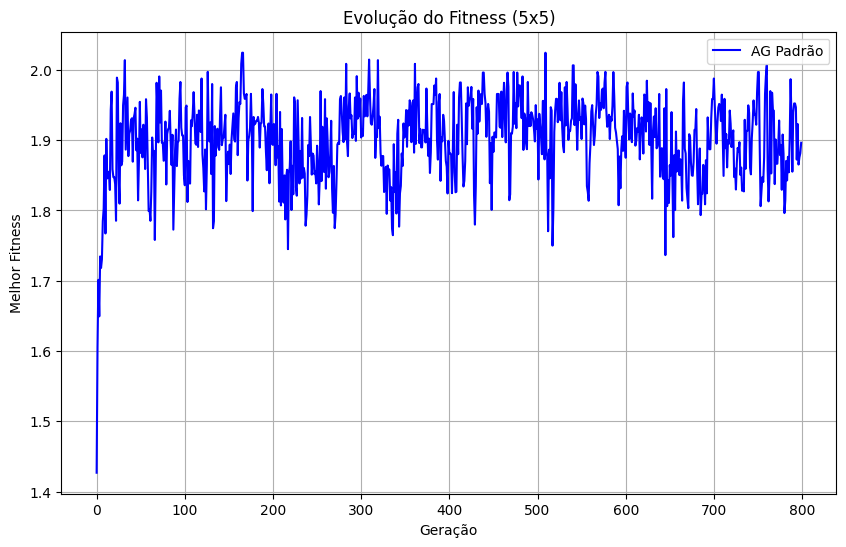

In [17]:
print(history_simple)
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(history_simple)), 
    history_simple, 
    'b-', 
    label='AG Padrão'
)
plt.title('Evolução do Fitness (5x5)')
plt.xlabel('Geração')
plt.ylabel('Melhor Fitness')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.grid(True)
plt.savefig('evolucao_fitness.png', dpi=300)
plt.show()

0  -  [1.3310190783303253, 1.1163485690171662, 1.1163485690171662, 1.3054098661297389, 1.340602102010759, 1.3409079779693074, 1.296062060452359, 1.3532894540252807, 1.3232164380410907, 1.36275127283389, 1.4115454227193003, 1.3111148428038781, 1.3239234283663006, 1.3216996492433222, 1.3604175770961628, 1.4057455486882984, 1.3535705612955713, 1.3985123350146549, 1.4036715352457771, 1.372713711775064, 1.3796720058031806, 1.4030846050910297, 1.4147113212054006, 1.4054284084190645, 1.4455065628735118, 1.397621829182785, 1.4123364799484381, 1.4321500529624647, 1.4276194162230238, 1.4245883393775145, 1.412746117197604, 1.4069959462812807, 1.4089314411857836, 1.3912933692877962, 1.4431414142986543, 1.4231613167268786, 1.4238878434143323, 1.4115454227193003, 1.4091811897203488, 1.4238050249252676, 1.4084695896685497, 1.4437908703720979, 1.4116796296277654, 1.4174461966628484, 1.3429115944164352, 1.3998665066646707, 1.373232991654976, 1.4066983987587598, 1.339211473391539, 1.3683624831990913, 1.

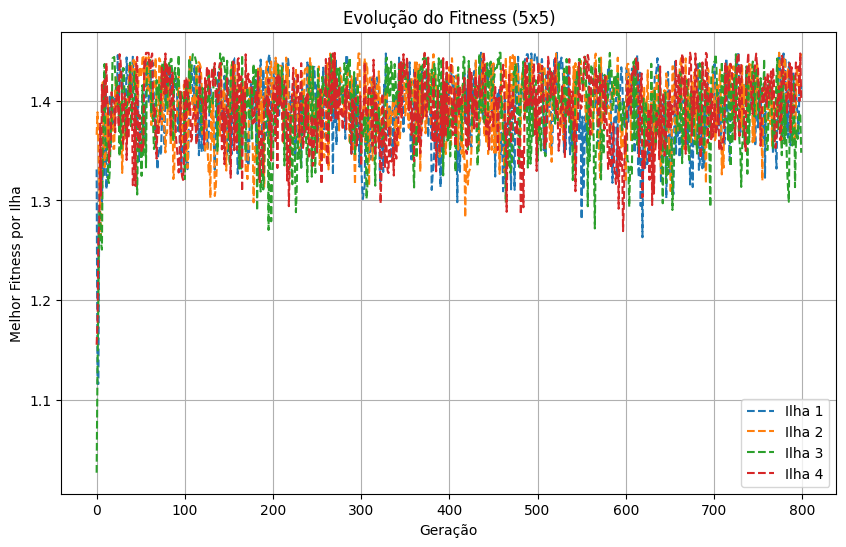

In [18]:
plt.figure(figsize=(10, 6))
for idx, history in enumerate(history_island):
    print(idx , " - " , history)
    plt.plot(
        range(len(history)),
        history,
        linestyle='--',
        label=f'Ilha {idx + 1}'
    )
plt.title('Evolução do Fitness (5x5)')
plt.xlabel('Geração')
plt.ylabel('Melhor Fitness por Ilha')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.grid(True)
plt.savefig('evolucao_fitness.png', dpi=300)
plt.show()

In [ ]:
# Testando diferentes tamanhos
for size in [50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]:
    POP_SIZE = size
    best, _ = best_realocate(initial_positions, min_matrix, max_matrix, b)
    print(f"POP_SIZE={size} | Fitness={best.fitness(tester)}")

POP_SIZE=50 | Fitness=1.0368737348549237


In [ ]:
# Testando taxas de mutação
POP_SIZE = 1000
for rate in [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4]:
    MU_TAX = rate
    best, _ = best_realocate(initial_positions, min_matrix, max_matrix, b)
    print(f"Taxa {rate}: Fitness={best.fitness(tester)}")

In [ ]:
# Migração com diferentes intervalos
POP_SIZE = 1000
MU_TAX = 0.05
for interval in [1, 5, 10, 15, 20, 25, 30]:
    best, _ = best_realocate_island(
        initial_positions,
        min_matrix,
        max_matrix,
        b,
        NUM_ISLAND,
        interval,
        MIGRATION_SIZE,
    )
    print(f"Intervalo {interval}: Fitness={best.fitness(tester)}")

In [ ]:
# Testando diferentes tamanhos de migração
POP_SIZE = 1000
MU_TAX = 0.05
MIGRATION_INT = 30
for size in [1, 2, 5, 10]:
    best, _ = best_realocate_island(
        initial_positions,
        min_matrix,
        max_matrix,
        b,
        NUM_ISLAND,
        MIGRATION_INT,
        size,
    )
    print(f"Tamanho {size}: Fitness={best.fitness(tester)}")